In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

from ultrayolo import YoloV3, losses
from ultrayolo.datasets import CocoFormatDataset, common
from ultrayolo.helpers import draw
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Yolo Loss Tutorial

The first create some random anchors and use the default masks

In [4]:
x = np.arange(5, 46, 5)
anchors = np.array(list(zip(x,x)), dtype=np.float32)
anchors[:,1] += np.random.randint(0, 10, 9)
anchors

array([[ 5.,  7.],
       [10., 12.],
       [15., 15.],
       [20., 24.],
       [25., 34.],
       [30., 30.],
       [35., 36.],
       [40., 45.],
       [45., 50.]], dtype=float32)

In [5]:
masks = YoloV3.default_masks
masks

array([[6, 7, 8],
       [3, 4, 5],
       [0, 1, 2]])

And load the dataset using the SequenceDataset
---

In [6]:
filepath = Path('./toy_dataset/data_annotations_train.txt')
target_shape = (512, 512, 3)
batch_size = 2
is_training = True
max_objects = 10


train_seq = CocoFormatDataset('../minicoco_dataset/hair_drier_toaster_bear.json',
                                  target_shape,
                                  max_objects,
                                  batch_size, 
                                  anchors,
                                  masks,
                                  is_training=is_training)

load coco annotations: 100%|██████████| 1714/1714 [00:00<00:00, 852690.91it/s]


In [7]:
train_seq.classes

[(23, 'bear'), (80, 'toaster'), (89, 'hair drier')]

Now we take a batch from the dataset
--

In [8]:
x_true, y_true_grids = train_seq[0]

The batch contains:
- 2 images

In [9]:
x_true.shape

(2, 512, 512, 3)

- 3 grids

In [10]:
for i in range(len(y_true_grids)): 
    print(i, '-->', y_true_grids[i].shape, target_shape[0] / y_true_grids[i].shape[1])

0 --> (2, 16, 16, 3, 8) 32.0
1 --> (2, 32, 32, 3, 8) 16.0
2 --> (2, 64, 64, 3, 8) 8.0


The third value plotted represents the size in number of pixel of grid cells

Check that the dataset transformed is correct
----

Show annotations for image 0
[0.         0.00375439 0.8535156  0.587484  ]
[  0   1 437 300]


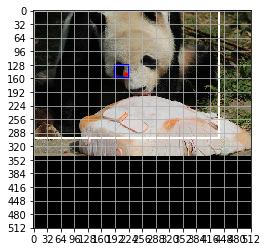

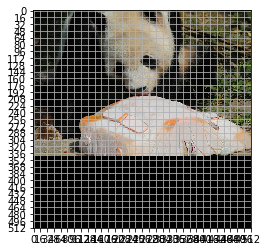

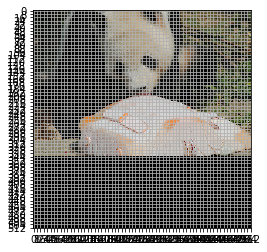

Show annotations for image 1
[0.44003123 0.464507   0.48345312 0.5184867 ]
[225 237 247 265]


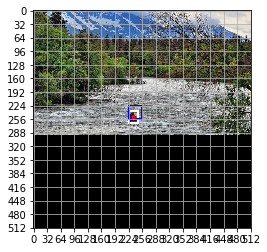

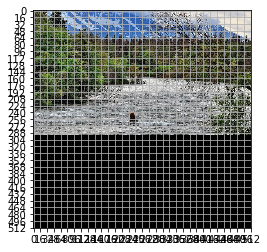

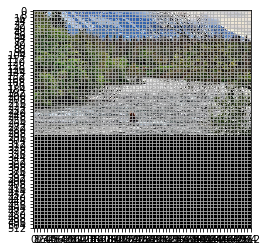

In [11]:
for img_idx in range(len(x_true)):
    print('Show annotations for image', img_idx)
    img = x_true[img_idx]

    for i in range(len(y_true_grids)):
        y_data_grid_img = y_true_grids[i][img_idx]
        
        ax = draw.show_img(img)
        grid_len = y_data_grid_img.shape[1]
        draw.grid(ax, img.shape[:2], grid_len)

        grid_cell_size = target_shape[1] / grid_len
        
        for grid_y, grid_x, box in np.argwhere(np.sum(y_data_grid_img[..., :4], axis=-1) > 0):
            box_xyxy = (y_data_grid_img[grid_y,grid_x,box, :4] * target_shape[0]).astype(int)
            class_id = np.argwhere(y_data_grid_img[grid_y,grid_x,box, 5:])[0][0]
            draw.rect(ax, box_xyxy, 'white', 1)
            print(y_data_grid_img[grid_y,grid_x,box, :4])
            print(box_xyxy)

            rect_resp = np.array([grid_x, grid_y]) * grid_cell_size
            rect_resp = np.concatenate([rect_resp, rect_resp + grid_cell_size])
            draw.rect(ax, rect_resp, 'blue', 2)

            draw.point(ax, common.to_center_width_height(box_xyxy)[:2])
        plt.show()

Create the model

In [12]:
model = YoloV3(target_shape, max_objects, 
               anchors=anchors, num_classes=train_seq.num_classes, 
               training=True, backbone='DarkNet')

## Evaluate how the loss works

We consider two cases:

1. when we got an initialized network the predictions should be around 0.5 (max entropy)
1. when we give as prediction the right labels the loss should be close to zero

In [13]:
y_pred_grids = model(x_true)
for y_pred in y_pred_grids:
    print(y_pred.shape)

(2, 16, 16, 3, 8)
(2, 32, 32, 3, 8)
(2, 64, 64, 3, 8)


We take i=0 since all the images are in the first grid

In [14]:
i = 0
y_true = y_true_grids[i]
y_pred = y_pred_grids[i]
y_pred = tf.slice(y_pred, begin=[0,0,0,0,0], size=y_true.shape)
anchors_masks = anchors[masks[i]]
img_size = target_shape[0]
loss_fn = losses.make_loss(train_seq.num_classes, anchors, masks, img_size, len(train_seq))
ignore_threshold = 0.7

### First Case

In [15]:
from ultrayolo.losses import YoloLoss

In [16]:
def to_box_xyxy(box_xy, box_wh, grid_size, anchors_masks):
    """convert the given boxes into the xy_min xy_max format
    Arguments:
        box_xy {tf.tensor} --
        box_wh {tf,tensor} --
        grid_size {float} -- the size of the grid used
        anchors_masks {tf.tensor} -- the anchor masks
    Returns:
        tf.tensor -- the boxes
    """
    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)    # [gx, gy, 1, 2]
    grid = tf.cast(grid, tf.float32)

    box_xy = (box_xy + grid) / tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors_masks

    box_wh = tf.where(tf.math.is_inf(box_wh), tf.zeros_like(box_wh), box_wh)

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    box_xyxy = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return box_xyxy

def process_predictions(y_pred, num_classes, anchors_masks):
    """process the predictions to transform from:
    -  pred_xy, pred_wh, pred_obj, pred_class
    into
    - box_xyxy, pred_obj, pred_class, pred_xywh

    Arguments:
        y_pred {tf.tensor} -- the predictions in the format 
            (NBATCH, x_center, y_center, width, heigth, obj, one_hot_classes)
        num_classes {int} -- the number of classes
        anchors_masks {tf.tensor} -- the anchors masks

    Returns:
        tuple -- box_xyxy, pred_obj, pred_class, pred_xywh
    """
    # anchors_masks = tf.gather(anchors, masks)

    pred_xy, pred_wh, pred_obj, pred_class = tf.split(y_pred,
                                                      (2, 2, 1, num_classes),
                                                      axis=-1)

    pred_xy = tf.sigmoid(pred_xy)
    pred_obj = tf.sigmoid(pred_obj)
    pred_class = tf.sigmoid(pred_class)
    pred_xywh = tf.concat((pred_xy, pred_wh), axis=-1)

    grid_size = tf.shape(y_pred)[1]
    box_xyxy = to_box_xyxy(pred_xy, pred_wh, grid_size, anchors_masks)

    return box_xyxy, pred_obj, pred_class, pred_xywh

In [17]:
# 1. transform all pred outputs
# y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
anchors_masks_scaled = anchors_masks / img_size
pred_xyxy, pred_obj, pred_class, pred_xywh = process_predictions(
            tf.cast(y_pred, tf.float32), train_seq.num_classes, anchors_masks_scaled
)
pred_xy = pred_xywh[..., 0:2]
pred_wh = pred_xywh[..., 2:4]

We expect that considering the variable `pred_xywh` the predictions should be:
- for xy in in average 0.5
- for wh close to 0
- for xy1, xy2 close to 0.5

While considering `pred_xyxy` it should be around 0.5

In [18]:
print('average xy', tf.reduce_mean(pred_xy))
print('average hw', tf.reduce_mean(pred_wh))
print('average xyxy', tf.reduce_mean(pred_xyxy))

average xy tf.Tensor(0.5, shape=(), dtype=float32)
average hw tf.Tensor(1.2739657e-09, shape=(), dtype=float32)
average xyxy tf.Tensor(0.5, shape=(), dtype=float32)


This is valid for all the objecteness and classes

In [21]:
print('average pred_obj', tf.reduce_mean(pred_obj))
print('average pred_class', tf.reduce_mean(pred_class))

average pred_obj tf.Tensor(0.5, shape=(), dtype=float32)
average pred_class tf.Tensor(0.5, shape=(), dtype=float32)


In [22]:
# 2. transform all true outputs
# y_true: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
true_box_xyxy, true_obj, true_class = tf.split(
    y_true, (4, 1, train_seq.num_classes), axis=-1)
true_xy = (true_box_xyxy[..., 0:2] + true_box_xyxy[..., 2:4]) / 2
true_wh = true_box_xyxy[..., 2:4] - true_box_xyxy[..., 0:2]

In [23]:
box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

3. inverting the pred box equations, to make it comparable with the transformations done for the predictions

In [24]:
grid_size = tf.shape(y_true)[1]
grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
    tf.cast(grid, tf.float32)

true_wh = tf.math.log(true_wh / anchors_masks_scaled)
true_wh = tf.where(tf.math.is_inf(true_wh),
                   tf.zeros_like(true_wh), true_wh)

The line 8 contains the opposite transformation made for the predictions

```
box_wh = tf.exp(box_wh) * anchors_masks
```

The masks are used to:
1. separate the boxes that contain objects and should be considered in the objects loss
2. from the boxes that not contain objects and should be considered in the **no object loss**

In [25]:
# 4. calculate all masks
obj_mask = tf.squeeze(true_obj, -1)
# ignore false positive when iou is over threshold
true_box_mask = tf.boolean_mask(
    true_box_xyxy, tf.cast(obj_mask, tf.bool))
best_iou = tf.reduce_max(YoloLoss.broadcast_iou(
    pred_xyxy, true_box_mask), axis=-1)
ignore_mask = tf.cast(best_iou < ignore_threshold, tf.float32)

Compute all the losses

- xy, wh only with respect the objects that contains elements

In [26]:
xy_loss = obj_mask * box_loss_scale * \
    tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
wh_loss = obj_mask * box_loss_scale * \
    tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

- the object and no object loss

You can check the whenever the loss is different to zero in the `obj_loss` is zero in the `no_obj_loss` and vice-versa

In [27]:
obj_cross_entropy = tf.keras.metrics.binary_crossentropy(
    true_obj, pred_obj, from_logits=False)
obj_loss = obj_mask * obj_cross_entropy
no_obj_loss = (1 - obj_mask) * ignore_mask * obj_cross_entropy

- The class loss is computed only for the cells the contains objects

In [28]:
class_loss = obj_mask * tf.keras.metrics.binary_crossentropy(
            true_class, pred_class, from_logits=False)

- everything is reduced to one value per image

In [29]:
xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
no_obj_loss = tf.reduce_sum(no_obj_loss, axis=(1, 2, 3))
class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

loss = xy_loss + wh_loss + obj_loss + no_obj_loss + class_loss

loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([545.8325, 535.0147], dtype=float32)>

### Second Case

- y_true == y_pred

In [30]:
i = 0
y_true = y_true_grids[i]
y_pred = y_true

- Remember that y_pred is in format xy_min xy_max

In [31]:
pred_xyxy, pred_obj, pred_class = tf.split(
        y_pred, (4, 1, train_seq.num_classes), axis=-1)

pred_xy = (pred_xyxy[..., 0:2] + pred_xyxy[..., 2:4]) / 2
pred_wh = pred_xyxy[..., 2:4] - pred_xyxy[..., 0:2]

pred_xywh = tf.concat((pred_xy, pred_wh), axis=-1)

In [32]:
true_box_xyxy, true_obj, true_class = tf.split(
            y_true, (4, 1, train_seq.num_classes), axis=-1)
true_xy = (true_box_xyxy[..., 0:2] + true_box_xyxy[..., 2:4]) / 2
true_wh = true_box_xyxy[..., 2:4] - true_box_xyxy[..., 0:2]

In [33]:
box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

# 4. calculate all masks
obj_mask = tf.squeeze(true_obj, -1)
# ignore false positive when iou is over threshold
true_box_mask = tf.boolean_mask(
    true_box_xyxy, tf.cast(obj_mask, tf.bool))
best_iou = tf.reduce_max(YoloLoss.broadcast_iou(
    pred_xyxy, true_box_mask), axis=-1)
ignore_mask = tf.cast(best_iou < ignore_threshold, tf.float32)

In [34]:
# 5. compute all the losses
xy_loss = obj_mask * box_loss_scale * \
    tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
wh_loss = obj_mask * box_loss_scale * \
    tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

In [35]:
obj_cross_entropy = tf.keras.metrics.binary_crossentropy(
    true_obj, pred_obj, from_logits=False)
obj_loss = obj_mask * obj_cross_entropy
no_obj_loss = (1 - obj_mask) * ignore_mask * obj_cross_entropy

class_loss = obj_mask * tf.keras.metrics.binary_crossentropy(
    true_class, pred_class, from_logits=False)

In [36]:
xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
no_obj_loss = tf.reduce_sum(no_obj_loss, axis=(1, 2, 3))
class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

loss = xy_loss + wh_loss + obj_loss + no_obj_loss + class_loss
loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

The loss is 0 when the prediction is equal to the true values

## Conclusion

we have verified that the loss:
- return max entropy value when the network is initialized, and
- return 0 when the y_pred is equal to y_true